In [1]:
%cd ../

/home/zulqarnain/algorithm16_skipped/htfatorch


In [2]:
import logging
import numpy as np
import htfa_torch.dtfa as DTFA
import htfa_torch.niidb as niidb
import htfa_torch.utils as utils
import matplotlib.pyplot as plt

/home/zulqarnain/anaconda3/envs/htfatorch/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
import itertools
from torch.nn.functional import softplus
import matplotlib.patches as mpatches
from ordered_set import OrderedSet

In [4]:
import torch

torch.cuda.set_device(0)

In [5]:
%matplotlib inline

In [6]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [7]:
def task_labeler(task):
    return task


def rest_task_labeler(task):
    if task == 'rest':
        return 'Rest'
    else:
        return 'Task'

In [8]:
def subject_labeler(subject):
    return str(subject)

In [9]:
def stimulus_labeler(stimulus):
    stim = stimulus[-1]
    if int(stim) == 1 or int(stim) == 2:
        return 'State 0'
    elif int(stim) == 3 or int(stim) == 4:
        return 'State 1'
    elif int(stim) == 5 or int(stim) == 6:
        return 'State 2'
    elif int(stim) == 7 or int(stim) == 8:
        return 'State 3'
    else:
        print ('Error')

In [10]:
def scatter_interactions_embedding(self, labeler=None, filename='', show=True,
                                   xlims=None, ylims=None, figsize=utils.FIGSIZE,
                                   colormap='Accent', serialize_data=True,
                                   plot_ellipse=True, legend_ordering=None,nstd=3):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]
    
    if filename == '':
        filename = self.common_name() + '_task_embedding.pdf'
    hyperparams = self.variational.hyperparams.state_vardict()
    tasks = self.tasks()
    subjects = self.subjects()
    z_p_mu = hyperparams['subject_weight']['mu'].data
    z_s_mu = hyperparams['task']['mu'].data
    interactions = OrderedSet(list(itertools.product(subjects, tasks)))
    z_ps_mu = np.zeros(shape=(len(interactions),2))
    count = 0
    for p in range (len(subjects)):
        for t in range(len(tasks)):
            joint_embed = torch.cat((z_p_mu[p], z_s_mu[t]), dim=-1)
            interaction_embed = self.decoder.interaction_embedding(
                joint_embed).data
            z_ps_mu[count,:] = self.decoder.interaction_embedding_out(torch.cat((interaction_embed,
                                                                                 joint_embed),dim=-1)).data.numpy()
            count += 1
    embedding_name = 'z^{PS}'
    fig, ax = plt.subplots(facecolor='white', figsize=figsize, frameon=True)
    if xlims is not None:
        ax.set_xlim(xlims)
    if ylims is not None:
        ax.set_ylim(ylims)
    ax.set_xticks([])
    ax.set_yticks([])
    task_colors = ['black','darkgreen','red','blue']
    task_low_embeddings = []
    task_high_embeddings = []

    for i in range(len(z_ps_mu)):
        if stimulus_labeler(interactions[i][1]) == 'State 0':
            edgecolor = task_colors[0]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[0], marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[0], marker='^', s=400, linewidth=4)
            task_low_embeddings.append(z_ps_mu[i,:])
        elif stimulus_labeler(interactions[i][1]) == 'State 1':
            edgecolor = task_colors[1]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 2':
            edgecolor = task_colors[2]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[2],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[2],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 3':
            edgecolor = task_colors[3]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[3],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[3],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 

    ordered_tasks = ['Baseline','Trial A', 'Trial B', 'Trial C']
    single_task_colors = ['darkgreen','red','blue']
    manual_legend = [mpatches.Patch(color=c,label=t) for (c,t) in zip(task_colors,ordered_tasks)]
    temp_dict = {key:[] for key in subjects}
    linestyle = ['solid','dashed']

    
    plt.legend(handles=manual_legend, prop={'size': 16})
    if filename is not None:
        fig.savefig(filename)
    if show:
        fig.show()

In [11]:
def interactions_labeler(subject,task):
    
    return task_labeler(task) + subject_labeler(subject)

10/08/2021 23:12:45 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_1/nifti_files/participant_1_video1_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:45 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_1/nifti_files/participant_1_video2_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:46 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_1/nifti_files/participant_1_video3_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:46 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects

10/08/2021 23:12:51 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_2/nifti_files/participant_2_video4_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:51 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_2/nifti_files/participant_2_video5_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:51 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_2/nifti_files/participant_2_video6_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:51 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjec

10/08/2021 23:12:56 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_8/nifti_files/participant_1_video7_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:56 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_8/nifti_files/participant_1_video8_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:56 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_8/nifti_files/participant_2_video1_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:12:56 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subject

10/08/2021 23:13:01 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_50/nifti_files/participant_1_video2_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:01 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_50/nifti_files/participant_1_video3_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:01 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_2_50/nifti_files/participant_1_video4_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:01 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subj

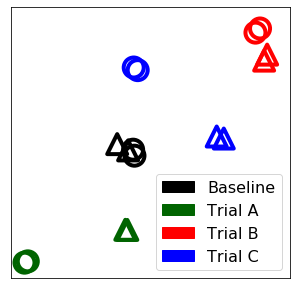

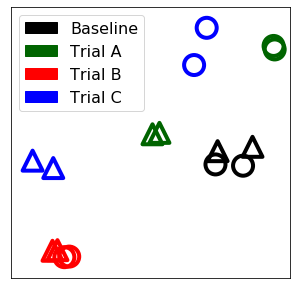

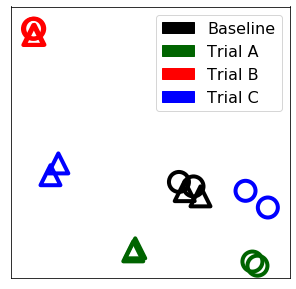

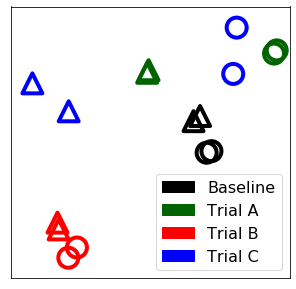

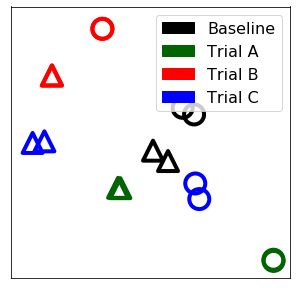

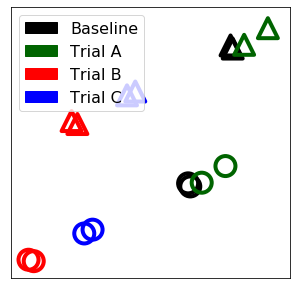

In [12]:
for noise_factor in [1, 2, 4, 8, 10, 50]:
    scenario = '3'
    # noise_factor = 2
    num_subjects = 2
    db_file = 'data/simulated_simplified_data_' + scenario + '_' + str(num_subjects)+ '_' + str(noise_factor) + '.db'
    scenario_name = 'scenario_' + scenario + '_' + str(num_subjects)+ '_' + str(noise_factor)
    TRAIN = True
    synthetic_db = niidb.FMriActivationsDb(db_file)
    dtfa = DTFA.DeepTFA(synthetic_db.all(), 
                        mask='/home/zulqarnain/fmri_data/simulated_degeneracy_data/wholebrain.nii.gz', 
                        num_factors=9, embedding_dim=2)
    dtfa.load_state('data/scenario_' + scenario + '_subjects_'  + str(num_subjects)+ '_' + str(noise_factor))
    scatter_interactions_embedding(dtfa,labeler=interactions_labeler,
                                   filename='subject_norest_interaction_embedding' + scenario_name + '.png',
                                   plot_ellipse=True,colormap='tab20',figsize=(5,5),nstd=2)

In [13]:
def scatter_interactions_embedding(self, labeler=None, filename='', show=True,
                                   xlims=None, ylims=None, figsize=utils.FIGSIZE,
                                   colormap='Accent', serialize_data=True,
                                   plot_ellipse=True, legend_ordering=None,nstd=3):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]
    
    if filename == '':
        filename = self.common_name() + '_task_embedding.pdf'
    hyperparams = self.variational.hyperparams.state_vardict()
    tasks = self.tasks()
    subjects = self.subjects()
    z_p_mu = hyperparams['subject_weight']['mu'].data
    z_s_mu = hyperparams['task']['mu'].data
    interactions = OrderedSet(list(itertools.product(subjects, tasks)))
    z_ps_mu = np.zeros(shape=(len(interactions),2))
    count = 0
    for p in range (len(subjects)):
        for t in range(len(tasks)):
            joint_embed = torch.cat((z_p_mu[p], z_s_mu[t]), dim=-1)
            interaction_embed = self.decoder.interaction_embedding(
                joint_embed).data
            z_ps_mu[count,:] = self.decoder.interaction_embedding_out(torch.cat((interaction_embed,
                                                                                 joint_embed),dim=-1)).data.numpy()
            count += 1
    embedding_name = 'z^{PS}'

    fig, ax = plt.subplots(facecolor='white', figsize=figsize, frameon=True)
    if xlims is not None:
        ax.set_xlim(xlims)
    if ylims is not None:
        ax.set_ylim(ylims)
    ax.set_xticks([])
    ax.set_yticks([])
    task_colors = ['black','darkgreen','red','blue']
    task_low_embeddings = []
    task_high_embeddings = []

    for i in range(len(z_ps_mu)):
        if stimulus_labeler(interactions[i][1]) == 'State 0':
            edgecolor = task_colors[0]
            ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[0], marker='o', s=10, linewidth=4)

            task_low_embeddings.append(z_ps_mu[i,:])
        elif stimulus_labeler(interactions[i][1]) == 'State 1':
            edgecolor = task_colors[1]
#             if str(interactions[i][0]) == '1':
            ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='o', s=10, linewidth=4)
#             else:
#                 ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 2':
            edgecolor = task_colors[2]
#             if str(interactions[i][0]) == '1':
            ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[2],marker='o', s=10, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 3':
            edgecolor = task_colors[3]
            ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[3],marker='o', s=10, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        ax.annotate(str(interactions[i][0]),(z_ps_mu[i,0],z_ps_mu[i,1]),fontsize=18)

    ordered_tasks = ['Baseline','Trial A', 'Trial B', 'Trial C']
    single_task_colors = ['darkgreen','red','blue']
    manual_legend = [mpatches.Patch(color=c,label=t) for (c,t) in zip(task_colors,ordered_tasks)]
    temp_dict = {key:[] for key in subjects}
    linestyle = ['solid','dashed']

    
    plt.legend(handles=manual_legend, prop={'size': 16})
    if filename is not None:
        fig.savefig(filename)
    if show:
        fig.show()


10/08/2021 23:13:04 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_10_video1_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:04 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_10_video2_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:04 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_10_video3_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:04 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_su

10/08/2021 23:13:08 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_13_video5_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:08 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_13_video6_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:08 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_13_video7_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:09 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_

10/08/2021 23:13:13 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_17_video1_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:13 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_17_video2_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:13 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_17_video3_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:13 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_su

10/08/2021 23:13:18 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_1_video5_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:18 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_1_video6_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:18 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_1_video7_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:18 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_sub

10/08/2021 23:13:25 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_4_video1_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:25 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_4_video2_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:25 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_4_video3_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:25 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subje

10/08/2021 23:13:30 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_7_video5_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:30 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_7_video6_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:30 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_subjects_20_1/nifti_files/participant_7_video7_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
10/08/2021 23:13:31 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/scenario_3_sub

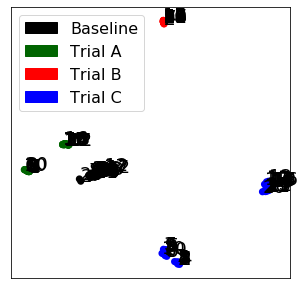

In [14]:
scenario = '3'
noise_factor = 1
num_subjects = 20
db_file = 'data/simulated_simplified_data_' + scenario + '_' + str(num_subjects)+ '_' + str(noise_factor) + '.db'
scenario_name = 'scenario_' + scenario + '_' + str(num_subjects)+ '_' + str(noise_factor)
TRAIN = True
synthetic_db = niidb.FMriActivationsDb(db_file)
dtfa = DTFA.DeepTFA(synthetic_db.all(), 
                    mask='/home/zulqarnain/fmri_data/simulated_degeneracy_data/wholebrain.nii.gz', 
                    num_factors=9, embedding_dim=2)
dtfa.load_state('data/scenario_' + scenario + '_subjects_'  + str(num_subjects)+ '_' + str(noise_factor))
scatter_interactions_embedding(dtfa,labeler=interactions_labeler,
                               filename='subject_norest_interaction_embedding' + scenario_name + '.png',
                               plot_ellipse=True,colormap='tab20',figsize=(5,5),nstd=2)